In [1]:
import torch
from torch.utils.data import Dataset, DataLoader

# Load tokenized data
print("Loading tokenized data...")
checkpoint = torch.load('tokenized_data.pt', weights_only=False)
data = checkpoint['data']
char_to_idx = checkpoint['char_to_idx']
idx_to_char = checkpoint['idx_to_char']
vocab_size = checkpoint['vocab_size']

print(f"✓ Data loaded: {len(data):,} tokens")
print(f"✓ Vocabulary size: {vocab_size}")

print("\n" + "="*60)
print("CREATING DATASET")
print("="*60)

class CharDataset(Dataset):
    def __init__(self, data, seq_len):
        self.data = data
        self.seq_len = seq_len
    
    def __len__(self):
        return len(self.data) - self.seq_len
    
    def __getitem__(self, idx):
        # Get sequence of seq_len + 1 tokens
        chunk = self.data[idx:idx + self.seq_len + 1]
        
        # Input: first seq_len tokens
        x = chunk[:-1]
        
        # Target: shifted by 1 (next character prediction)
        y = chunk[1:]
        
        return x, y

# Create dataset
seq_len = 64  # Context length
batch_size = 32

dataset = CharDataset(data, seq_len)

print(f"Sequence length: {seq_len}")
print(f"Total sequences: {len(dataset):,}")

# Split into train/val
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size]
)

print(f"\nTrain sequences: {len(train_dataset):,}")
print(f"Val sequences: {len(val_dataset):,}")

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"\nBatch size: {batch_size}")
print(f"Train batches: {len(train_loader):,}")
print(f"Val batches: {len(val_loader):,}")

print("\n" + "="*60)
print("EXAMINING ONE BATCH")
print("="*60)

# Get one batch
x_batch, y_batch = next(iter(train_loader))

print(f"Input batch shape: {x_batch.shape}")  # [batch_size, seq_len]
print(f"Target batch shape: {y_batch.shape}")  # [batch_size, seq_len]

# Show first sequence
print("\n" + "="*60)
print("FIRST SEQUENCE IN BATCH")
print("="*60)

x_sample = x_batch[0]
y_sample = y_batch[0]

# Decode to text
x_text = ''.join([idx_to_char[i.item()] for i in x_sample])
y_text = ''.join([idx_to_char[i.item()] for i in y_sample])

print("Input text:")
print(f"'{x_text}'")
print("\nTarget text (shifted by 1):")
print(f"'{y_text}'")

# Show token-by-token
print("\n" + "="*60)
print("TOKEN-BY-TOKEN VIEW (first 10 positions)")
print("="*60)
print("Position | Input Char | Input ID | Target Char | Target ID")
print("-" * 60)
for i in range(10):
    in_char = idx_to_char[x_sample[i].item()]
    in_id = x_sample[i].item()
    tgt_char = idx_to_char[y_sample[i].item()]
    tgt_id = y_sample[i].item()
    print(f"{i:8d} | {in_char:10s} | {in_id:8d} | {tgt_char:11s} | {tgt_id:9d}")

print("\n✓ Notice: Target is input shifted by 1 position")
print("  Model learns: given input, predict next character")

# Save just config and data (NOT the loaders or dataset objects)
torch.save({
    'data': data,
    'vocab_size': vocab_size,
    'idx_to_char': idx_to_char,
    'char_to_idx': char_to_idx,
    'seq_len': seq_len,
    'batch_size': batch_size,
    'train_size': train_size,
    'val_size': val_size
}, 'dataset_config.pt')

print("\n" + "="*60)
print("STEP 3 COMPLETE ✓")
print("="*60)
print("✓ Dataset created")
print("✓ Split into train/val")
print("✓ DataLoaders ready")
print("✓ Config saved")
print("✓ Ready to build model!")

Loading tokenized data...
✓ Data loaded: 54,050 tokens
✓ Vocabulary size: 34

CREATING DATASET
Sequence length: 64
Total sequences: 53,986

Train sequences: 48,587
Val sequences: 5,399

Batch size: 32
Train batches: 1,519
Val batches: 169

EXAMINING ONE BATCH
Input batch shape: torch.Size([32, 64])
Target batch shape: torch.Size([32, 64])

FIRST SEQUENCE IN BATCH
Input text:
'purr loudly. Tom loved his cat very much.
One day the cat chased'

Target text (shifted by 1):
'urr loudly. Tom loved his cat very much.
One day the cat chased '

TOKEN-BY-TOKEN VIEW (first 10 positions)
Position | Input Char | Input ID | Target Char | Target ID
------------------------------------------------------------
       0 | p          |       26 | u           |        30
       1 | u          |       30 | r           |        27
       2 | r          |       27 | r           |        27
       3 | r          |       27 |             |         1
       4 |            |        1 | l           |        22
  

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

print("="*60)
print("BUILDING GPT MODEL FROM SCRATCH")
print("="*60)

# Load data config
checkpoint = torch.load('dataset_config.pt', weights_only=False)
vocab_size = checkpoint['vocab_size']
seq_len = checkpoint['seq_len']

print(f"\nVocabulary size: {vocab_size}")
print(f"Sequence length: {seq_len}")

# Model hyperparameters
embedding_dim = 128
num_heads = 4
num_layers = 4
ff_dim = 512
dropout = 0.1

print(f"\nModel hyperparameters:")
print(f"  Embedding dimension: {embedding_dim}")
print(f"  Number of heads: {num_heads}")
print(f"  Number of layers: {num_layers}")
print(f"  Feed-forward dimension: {ff_dim}")
print(f"  Dropout: {dropout}")

print("\n" + "="*60)
print("COMPONENT 1: MULTI-HEAD ATTENTION")
print("="*60)

class MultiHeadAttention(nn.Module):
    def __init__(self, embedding_dim, num_heads, dropout):
        super().__init__()
        assert embedding_dim % num_heads == 0
        
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.head_dim = embedding_dim // num_heads
        
        self.W_q = nn.Linear(embedding_dim, embedding_dim, bias=False)
        self.W_k = nn.Linear(embedding_dim, embedding_dim, bias=False)
        self.W_v = nn.Linear(embedding_dim, embedding_dim, bias=False)
        self.W_o = nn.Linear(embedding_dim, embedding_dim, bias=False)
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, mask=None):
        batch_size, seq_len, _ = x.shape
        
        Q = self.W_q(x)
        K = self.W_k(x)
        V = self.W_v(x)
        
        # Split into multiple heads
        Q = Q.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        
        # Attention
        attention_scores = Q @ K.transpose(-2, -1) / (self.head_dim ** 0.5)
        
        if mask is not None:
            attention_scores = attention_scores.masked_fill(mask == 0, float('-inf'))
        
        attention_weights = F.softmax(attention_scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        
        attended = attention_weights @ V
        
        # Concatenate heads
        attended = attended.transpose(1, 2).contiguous()
        attended = attended.view(batch_size, seq_len, self.embedding_dim)
        
        output = self.W_o(attended)
        
        return output, attention_weights

print("✓ Multi-Head Attention defined")

print("\n" + "="*60)
print("COMPONENT 2: FEED-FORWARD NETWORK")
print("="*60)

class FeedForward(nn.Module):
    def __init__(self, embedding_dim, ff_dim, dropout):
        super().__init__()
        self.linear1 = nn.Linear(embedding_dim, ff_dim)
        self.linear2 = nn.Linear(ff_dim, embedding_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        # Expand
        x = self.linear1(x)
        x = F.gelu(x)
        x = self.dropout(x)
        
        # Compress
        x = self.linear2(x)
        x = self.dropout(x)
        
        return x

print("✓ Feed-Forward Network defined")

print("\n" + "="*60)
print("COMPONENT 3: TRANSFORMER BLOCK")
print("="*60)

class TransformerBlock(nn.Module):
    def __init__(self, embedding_dim, num_heads, ff_dim, dropout):
        super().__init__()
        
        self.attention = MultiHeadAttention(embedding_dim, num_heads, dropout)
        self.feed_forward = FeedForward(embedding_dim, ff_dim, dropout)
        
        self.norm1 = nn.LayerNorm(embedding_dim)
        self.norm2 = nn.LayerNorm(embedding_dim)
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, mask=None):
        # Attention with residual
        attended, attn_weights = self.attention(self.norm1(x), mask)
        x = x + self.dropout(attended)
        
        # Feed-forward with residual
        ff_out = self.feed_forward(self.norm2(x))
        x = x + self.dropout(ff_out)
        
        return x, attn_weights

print("✓ Transformer Block defined")

print("\n" + "="*60)
print("COMPONENT 4: COMPLETE GPT MODEL")
print("="*60)

class GPT(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_heads, num_layers, ff_dim, seq_len, dropout):
        super().__init__()
        
        # Embeddings (BASELINE EMBEDDINGS CREATED HERE!)
        self.token_embedding = nn.Embedding(vocab_size, embedding_dim)
        self.position_embedding = nn.Embedding(seq_len, embedding_dim)
        
        # Transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(embedding_dim, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])
        
        # Output
        self.ln_f = nn.LayerNorm(embedding_dim)
        self.head = nn.Linear(embedding_dim, vocab_size)
        
        self.dropout = nn.Dropout(dropout)
        self.seq_len = seq_len
        
        # Initialize weights
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
    
    def forward(self, x):
        batch_size, seq_len = x.shape
        
        # Create causal mask (prevent looking at future tokens)
        mask = torch.tril(torch.ones(seq_len, seq_len)).view(1, 1, seq_len, seq_len)
        mask = mask.to(x.device)
        
        # Embeddings
        token_emb = self.token_embedding(x)
        pos = torch.arange(seq_len, device=x.device)
        pos_emb = self.position_embedding(pos)
        
        x = self.dropout(token_emb + pos_emb)
        
        # Transformer blocks
        attention_weights = []
        for block in self.blocks:
            x, attn = block(x, mask)
            attention_weights.append(attn)
        
        # Output
        x = self.ln_f(x)
        logits = self.head(x)
        
        return logits, attention_weights

print("✓ Complete GPT model defined")

# Create model
model = GPT(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    num_heads=num_heads,
    num_layers=num_layers,
    ff_dim=ff_dim,
    seq_len=seq_len,
    dropout=dropout
)

print("\n" + "="*60)
print("MODEL ARCHITECTURE")
print("="*60)
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("\n" + "="*60)
print("MODEL STATISTICS")
print("="*60)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size: ~{total_params * 4 / 1024 / 1024:.2f} MB")

# Test forward pass
print("\n" + "="*60)
print("TEST FORWARD PASS")
print("="*60)

dummy_input = torch.randint(0, vocab_size, (2, seq_len))
print(f"Input shape: {dummy_input.shape}")

with torch.no_grad():
    logits, attn_weights = model(dummy_input)
    
print(f"Output logits shape: {logits.shape}")
print(f"Number of attention weight tensors: {len(attn_weights)}")
print(f"Each attention weight shape: {attn_weights[0].shape}")

print("\n✓ Forward pass successful!")

# Save model state dict (better practice)
torch.save({
    'model_state_dict': model.state_dict(),
    'embedding_dim': embedding_dim,
    'num_heads': num_heads,
    'num_layers': num_layers,
    'ff_dim': ff_dim,
    'vocab_size': vocab_size,
    'seq_len': seq_len,
    'dropout': dropout
}, 'model_checkpoint_init.pt')

print("\n" + "="*60)
print("STEP 4 COMPLETE ✓")
print("="*60)
print("✓ Model architecture built")
print("✓ Baseline embeddings created (random)")
print("✓ Model checkpoint saved")
print("✓ Ready for inspection and training!")

BUILDING GPT MODEL FROM SCRATCH

Vocabulary size: 34
Sequence length: 64

Model hyperparameters:
  Embedding dimension: 128
  Number of heads: 4
  Number of layers: 4
  Feed-forward dimension: 512
  Dropout: 0.1

COMPONENT 1: MULTI-HEAD ATTENTION
✓ Multi-Head Attention defined

COMPONENT 2: FEED-FORWARD NETWORK
✓ Feed-Forward Network defined

COMPONENT 3: TRANSFORMER BLOCK
✓ Transformer Block defined

COMPONENT 4: COMPLETE GPT MODEL
✓ Complete GPT model defined

MODEL ARCHITECTURE
GPT(
  (token_embedding): Embedding(34, 128)
  (position_embedding): Embedding(64, 128)
  (blocks): ModuleList(
    (0-3): 4 x TransformerBlock(
      (attention): MultiHeadAttention(
        (W_q): Linear(in_features=128, out_features=128, bias=False)
        (W_k): Linear(in_features=128, out_features=128, bias=False)
        (W_v): Linear(in_features=128, out_features=128, bias=False)
        (W_o): Linear(in_features=128, out_features=128, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
     

INSPECTING UNTRAINED MODEL
✓ Model loaded (untrained/random weights)

TEST 1: INSPECT EMBEDDINGS

Embeddings (first 10 dimensions):
'T': [-0.0062409   0.04368081 -0.0191368  -0.01765813 -0.00492677  0.03837962
  0.01010672 -0.01347437 -0.010448   -0.01498996]
'h': [ 0.02938294  0.02354991  0.00128523  0.00768346  0.01869294  0.01333645
 -0.00678129  0.00561059  0.00320393  0.00159857]
'e': [ 0.00081883 -0.04253924 -0.00108659  0.01334755  0.00651216 -0.00716263
 -0.03470825  0.03700183 -0.02439357 -0.01420929]
' ': [-0.00508964 -0.02576851  0.01050834  0.03502115  0.02624016 -0.03784408
  0.02501038 -0.01042407  0.00990339  0.01270693]
'c': [ 0.00446888 -0.01056841  0.0025781   0.02844588 -0.0224325   0.02332008
 -0.00509204  0.00189248  0.01883903 -0.0045165 ]
'a': [-0.00232707 -0.02534795  0.01866626 -0.02250614 -0.00877226 -0.00514795
  0.010697   -0.00483317 -0.03743403 -0.01006311]
't': [-3.2987725e-02 -8.7468135e-05 -1.4646525e-04 -7.9643354e-03
  8.1091290e-03  5.8559916e-04 -9.

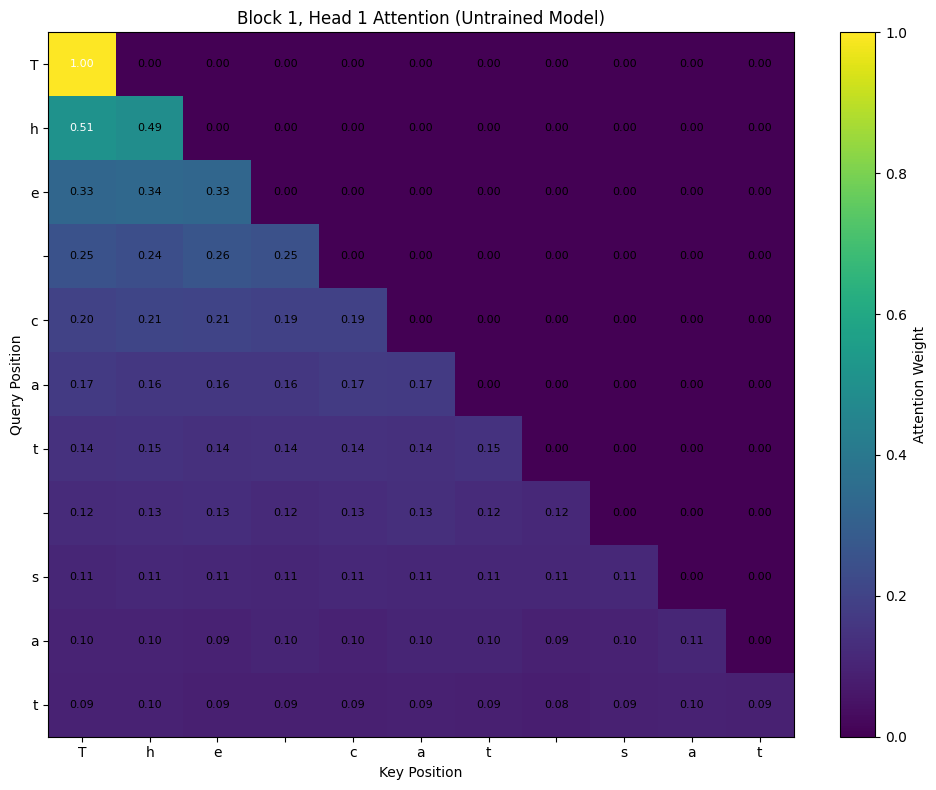

✓ Attention plot saved: attention_untrained.png
(Patterns should look random/uniform)

CHECKPOINT: UNTRAINED MODEL ✓
✓ Embeddings are random
✓ Generated text is gibberish
✓ Attention patterns are random

Next: Train for 5 epochs and see what changes!


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

print("="*60)
print("INSPECTING UNTRAINED MODEL")
print("="*60)

# Load model checkpoint
checkpoint = torch.load('model_checkpoint_init.pt', weights_only=False)

# Load tokenizer info
data_config = torch.load('dataset_config.pt', weights_only=False)
idx_to_char = data_config['idx_to_char']
char_to_idx = data_config['char_to_idx']

# Rebuild model (need class definitions)
embedding_dim = checkpoint['embedding_dim']
num_heads = checkpoint['num_heads']
num_layers = checkpoint['num_layers']
ff_dim = checkpoint['ff_dim']
vocab_size = checkpoint['vocab_size']
seq_len = checkpoint['seq_len']
dropout = checkpoint['dropout']

# Copy model classes from step 4
class MultiHeadAttention(nn.Module):
    def __init__(self, embedding_dim, num_heads, dropout):
        super().__init__()
        assert embedding_dim % num_heads == 0
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.head_dim = embedding_dim // num_heads
        self.W_q = nn.Linear(embedding_dim, embedding_dim, bias=False)
        self.W_k = nn.Linear(embedding_dim, embedding_dim, bias=False)
        self.W_v = nn.Linear(embedding_dim, embedding_dim, bias=False)
        self.W_o = nn.Linear(embedding_dim, embedding_dim, bias=False)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, mask=None):
        batch_size, seq_len, _ = x.shape
        Q = self.W_q(x)
        K = self.W_k(x)
        V = self.W_v(x)
        Q = Q.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        attention_scores = Q @ K.transpose(-2, -1) / (self.head_dim ** 0.5)
        if mask is not None:
            attention_scores = attention_scores.masked_fill(mask == 0, float('-inf'))
        attention_weights = F.softmax(attention_scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        attended = attention_weights @ V
        attended = attended.transpose(1, 2).contiguous()
        attended = attended.view(batch_size, seq_len, self.embedding_dim)
        output = self.W_o(attended)
        return output, attention_weights

class FeedForward(nn.Module):
    def __init__(self, embedding_dim, ff_dim, dropout):
        super().__init__()
        self.linear1 = nn.Linear(embedding_dim, ff_dim)
        self.linear2 = nn.Linear(ff_dim, embedding_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        x = self.linear1(x)
        x = F.gelu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.dropout(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, embedding_dim, num_heads, ff_dim, dropout):
        super().__init__()
        self.attention = MultiHeadAttention(embedding_dim, num_heads, dropout)
        self.feed_forward = FeedForward(embedding_dim, ff_dim, dropout)
        self.norm1 = nn.LayerNorm(embedding_dim)
        self.norm2 = nn.LayerNorm(embedding_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, mask=None):
        attended, attn_weights = self.attention(self.norm1(x), mask)
        x = x + self.dropout(attended)
        ff_out = self.feed_forward(self.norm2(x))
        x = x + self.dropout(ff_out)
        return x, attn_weights

class GPT(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_heads, num_layers, ff_dim, seq_len, dropout):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, embedding_dim)
        self.position_embedding = nn.Embedding(seq_len, embedding_dim)
        self.blocks = nn.ModuleList([
            TransformerBlock(embedding_dim, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])
        self.ln_f = nn.LayerNorm(embedding_dim)
        self.head = nn.Linear(embedding_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.seq_len = seq_len
    
    def forward(self, x):
        batch_size, seq_len = x.shape
        mask = torch.tril(torch.ones(seq_len, seq_len)).view(1, 1, seq_len, seq_len)
        mask = mask.to(x.device)
        token_emb = self.token_embedding(x)
        pos = torch.arange(seq_len, device=x.device)
        pos_emb = self.position_embedding(pos)
        x = self.dropout(token_emb + pos_emb)
        attention_weights = []
        for block in self.blocks:
            x, attn = block(x, mask)
            attention_weights.append(attn)
        x = self.ln_f(x)
        logits = self.head(x)
        return logits, attention_weights

# Create model and load weights
model = GPT(vocab_size, embedding_dim, num_heads, num_layers, ff_dim, seq_len, dropout)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print("✓ Model loaded (untrained/random weights)")

print("\n" + "="*60)
print("TEST 1: INSPECT EMBEDDINGS")
print("="*60)

# Look at embeddings for a few characters
test_chars = ['T', 'h', 'e', ' ', 'c', 'a', 't']
test_ids = [char_to_idx[ch] for ch in test_chars]

with torch.no_grad():
    embeddings = model.token_embedding(torch.tensor(test_ids))

print("\nEmbeddings (first 10 dimensions):")
for char, emb in zip(test_chars, embeddings):
    print(f"'{char}': {emb[:10].numpy()}")

# Check if similar characters have similar embeddings (they shouldn't yet - random!)
print("\n" + "="*60)
print("SIMILARITY CHECK (Should be random)")
print("="*60)

def cosine_similarity(a, b):
    return (a @ b) / (torch.norm(a) * torch.norm(b))

with torch.no_grad():
    t_emb = model.token_embedding(torch.tensor([char_to_idx['T']]))
    h_emb = model.token_embedding(torch.tensor([char_to_idx['h']]))
    space_emb = model.token_embedding(torch.tensor([char_to_idx[' ']]))

print(f"Similarity 'T' vs 'h': {cosine_similarity(t_emb[0], h_emb[0]):.3f}")
print(f"Similarity 'T' vs ' ': {cosine_similarity(t_emb[0], space_emb[0]):.3f}")
print("(Random weights = random similarities)")

print("\n" + "="*60)
print("TEST 2: GENERATE TEXT (Random Model)")
print("="*60)

def generate(model, prompt, max_tokens=50):
    model.eval()
    tokens = [char_to_idx[ch] for ch in prompt]
    
    with torch.no_grad():
        for _ in range(max_tokens):
            # Get last seq_len tokens
            context = tokens[-seq_len:] if len(tokens) > seq_len else tokens
            x = torch.tensor([context], dtype=torch.long)
            
            # Pad if needed
            if x.size(1) < seq_len:
                padding = torch.zeros(1, seq_len - x.size(1), dtype=torch.long)
                x = torch.cat([x, padding], dim=1)
            
            logits, _ = model(x)
            
            # Get last position prediction
            next_token_logits = logits[0, len(context)-1, :]
            probs = F.softmax(next_token_logits, dim=0)
            next_token = torch.multinomial(probs, 1).item()
            
            tokens.append(next_token)
            
            # Stop at newline or if generating too long
            if idx_to_char[next_token] == '\n':
                break
    
    return ''.join([idx_to_char[t] for t in tokens])

prompt = "The cat"
generated = generate(model, prompt, max_tokens=100)

print(f"Prompt: '{prompt}'")
print(f"Generated: '{generated}'")
print("\n(This should be gibberish - model is untrained!)")

print("\n" + "="*60)
print("TEST 3: ATTENTION PATTERNS (Random)")
print("="*60)

# Get attention for a sample input
sample_text = "The cat sat"
sample_ids = [char_to_idx[ch] for ch in sample_text]
x = torch.tensor([sample_ids], dtype=torch.long)

with torch.no_grad():
    logits, attention_weights = model(x)

# Visualize attention from first block, first head
attn = attention_weights[0][0, 0].numpy()  # [seq_len, seq_len]

plt.figure(figsize=(10, 8))
plt.imshow(attn, cmap='viridis', aspect='auto')
plt.colorbar(label='Attention Weight')
plt.xlabel('Key Position')
plt.ylabel('Query Position')
plt.title('Block 1, Head 1 Attention (Untrained Model)')

# Add character labels
positions = list(range(len(sample_text)))
plt.xticks(positions, list(sample_text))
plt.yticks(positions, list(sample_text))

# Add values
for i in range(len(sample_text)):
    for j in range(len(sample_text)):
        plt.text(j, i, f'{attn[i,j]:.2f}', ha='center', va='center', 
                color='white' if attn[i,j] > 0.5 else 'black', fontsize=8)

plt.tight_layout()
plt.savefig('attention_untrained.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Attention plot saved: attention_untrained.png")
print("(Patterns should look random/uniform)")

print("\n" + "="*60)
print("CHECKPOINT: UNTRAINED MODEL ✓")
print("="*60)
print("✓ Embeddings are random")
print("✓ Generated text is gibberish")
print("✓ Attention patterns are random")
print("\nNext: Train for 5 epochs and see what changes!")

In [6]:
prompt = "The cat"
generated = generate(model, prompt, max_tokens=100)
generated

'The catvHfllgg hLOevdiddlf sre ,duWuHtTsiscda.fdt HnWvsrriHwt.Tm E\n'